# Replication Code

Required packages:
   * jupyter
   * matplotlib
   * numpy
   * pandas
   * pickle
   * scikit-learn
   * scipy
   * seaborn
   * statsmodels
   * tqdm

In [1]:
import matplotlib
matplotlib.rcParams["hatch.color"] = "black"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
import statsmodels.formula.api as sm
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map, process_map

## Get submissions to ICLR 2017 - 2020

In [2]:
papers = {}
papers[2017] = pd.read_hdf("iclr2017_papers.hd5")[["submission_id", "author_names", "author_emails"]]
papers[2018] = pd.read_hdf("iclr2018_papers.hd5")[["submission_id", "author_names", "author_emails", "title"]]
papers[2019] = pd.read_hdf("iclr2019_papers.hd5")[["submission_id", "author_names", "author_emails"]]
papers[2020] = pd.read_hdf("iclr2020_papers.hd5")[["submission_id", "author_names", "author_emails"]]

# fix affiliations (or affiliation domains) parsed from PDF in ICLR 2017
affiliations_2017 = pd.read_hdf("iclr2017_affiliations.hd5")
papers[2017] = pd.merge(left=papers[2017], right=affiliations_2017, left_on="submission_id",
                       right_on="submission_id", validate="one_to_one")
papers[2017] = papers[2017].drop(columns=["author_emails"]).rename({"author_emails_pdf": "author_emails"}, axis=1)

## Read author affiliations, construct affiliation-based subgroups (Table 1, first column)

In [3]:
domain_map = pickle.load(open("domain_map.p", "rb"))
def map_gmails(email_list):
    new_email_list = []
    for email in email_list.split(","):
        new_email = email
        if email in domain_map:
            new_email = domain_map[email]
        new_email_list.append(new_email)
    return ",".join(new_email_list)
papers[2018]["author_emails"] = papers[2018]["author_emails"].apply(map_gmails)
papers[2019]["author_emails"] = papers[2019]["author_emails"].apply(map_gmails)
papers[2020]["author_emails"] = papers[2020]["author_emails"].apply(map_gmails)

# remove withdrawn papers
iclr2018_withdrawn = papers[2018]["author_emails"].apply(lambda x: len(x)) == 0
papers[2018] = papers[2018][~iclr2018_withdrawn]

# manual fix for one paper in ICLR 2017
papers[2017].loc[papers[2017]["submission_id"]=="SJUdkecgx", "author_emails"] =\
    "masoud.faraki@data61.csiro.au,mehrtash.harandi@data61.csiro.au,fatih.porikli@data61.csiro.au"
papers[2017].loc[papers[2017]["submission_id"]=="SJUdkecgx", "title"] =\
    "WHEN METRIC LEARNING GOES HAND IN HAND WITH DIMENSIONALITY REDUCTION"

def mark_foreign(email_list):
    is_foreign = 1
    for email in email_list.split(","):
        domain = email.split(".")[-1]

        if domain in ["edu", "ca", "org", "mil", "gov"]:
            is_foreign = 0
            break  

        if domain == "com":
            is_foreign_com = 0
            for foreign_com in ["baidu", "tencent", "huawei", "samsung", "caiyunapp",
                                "qq", "163", "126", "navercorp", "hitachi", "xiaomi", "taobao",
                                "panasonic", "naverlabs", "fujitso", "toutiao", "alibaba", "yitu-inc",
                                "360.com", "mohakshah", "gmail", "googlemail", "live", "hotmail"]:
                if foreign_com in email:
                    is_foreign_com = 1
                    break
            
            if not is_foreign_com: # .com domain and not a foreign company
                is_foreign = 0
                break

    return is_foreign

papers[2017]["foreign"] = papers[2017]["author_emails"].apply(mark_foreign)
papers[2018]["foreign"] = papers[2018]["author_emails"].apply(mark_foreign)
papers[2019]["foreign"] = papers[2019]["author_emails"].apply(mark_foreign)
papers[2020]["foreign"] = papers[2020]["author_emails"].apply(mark_foreign)

print("Affiliation-based Subgroups: Proportion of papers in G_1 (%)")
for year in [2017, 2018, 2019, 2020]:
    print(" ", year, papers[year]["foreign"].mean() * 100.0)



Affiliation-based Subgroups: Proportion of papers in G_1 (%)
  2017 24.081632653061224
  2018 24.102564102564102
  2019 25.965801139962004
  2020 30.493446414803394


## Get paper abstracts, peer review ratings and text

In [4]:
reviews = {}
reviews[2017] = pd.read_hdf("iclr_2017_cleantext.hd5")
reviews[2018] = pd.read_hdf("iclr_2018_cleantext.hd5")
reviews[2019] = pd.read_hdf("iclr_2019_cleantext.hd5")
reviews[2020] = pd.read_hdf("iclr_2020_cleantext.hd5")

reviews[2017]["year"] = 2017
reviews[2018]["year"] = 2018
reviews[2019]["year"] = 2019
reviews[2020]["year"] = 2020

for year in [2017, 2018, 2019, 2020]:
    reviews[year] = pd.merge(left=reviews[year], right=papers[year],
                             left_on="submission_id", right_on="submission_id",
                             validate="many_to_one")

for year in [2017, 2018, 2019, 2020]:
    reviews[year] = pd.merge(reviews[year], pd.read_hdf("iclr_" + str(year) + "_cleanabstract.hd5"),
                             left_on="submission_id", right_on="submission_id", validate="many_to_one")

print("Dataset sizes:")
print("ICLR 2017:", len(papers[2017]), "papers,", len(reviews[2017]), "reviews")
print("ICLR 2018:", len(papers[2018]), "papers,", len(reviews[2018]), "reviews")
print("ICLR 2019:", len(papers[2019]), "papers,", len(reviews[2019]), "reviews")
print("ICLR 2020:", len(papers[2020]), "papers,", len(reviews[2020]), "reviews")

decisions = {}
decisions[2017] = pd.read_hdf("iclr2017_reviews.hd5")[["submission_id", "decision"]].dropna()
decisions[2018] = pd.read_hdf("iclr2018_reviews.hd5")[["submission_id", "decision"]].dropna()
decisions[2019] = pd.read_hdf("iclr2019_reviews.hd5")[["submission_id", "recommendation"]].dropna()
decisions[2020] = pd.read_hdf("iclr2020_reviews.hd5")[["submission_id", "recommendation"]].dropna()

num_accepted = {}
num_rejected = {}
for year in [2017, 2018, 2019, 2020]:
    if year < 2019:
        string = "decision"
    else:
        string = "recommendation"
    num_accepted[year] = (decisions[year][string].str.contains("Accept")).sum()
    num_rejected[year] = len(decisions[year]) - num_accepted[year]

Dataset sizes:
ICLR 2017: 490 papers, 1489 reviews
ICLR 2018: 975 papers, 2852 reviews
ICLR 2019: 1579 papers, 4764 reviews
ICLR 2020: 2594 papers, 7775 reviews


## Paper submission and acceptance statistics (Figure 1)

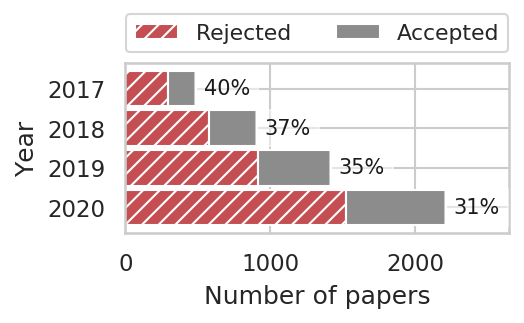

In [5]:
plt.figure(figsize=(3.3, 1.5), dpi=150)
years = [2017, 2018, 2019, 2020]
accepted = [num_accepted[year] for year in years][::-1]
rejected = [num_rejected[year] for year in years][::-1]
plt.barh(y=years, width=rejected, height=0.9, orientation="horizontal", color='C3', label="Rejected",
         hatch=3*"/")
plt.barh(y=years, width=accepted, height=0.9, orientation="horizontal", color='C7', label="Accepted", left=rejected)
acceptence_rates = ["{:.0f}%".format(a/(a+r)*100) for a, r in zip(accepted, rejected)]
for i in range(len(years)):
    year = years[i] - 0.1
    r = acceptence_rates[i]
    n = rejected[i] + accepted[i] + 50
    plt.text(n, year - 0.05, s=r, fontsize=10, color="k", bbox=dict(facecolor='white', alpha=0.5))
plt.yticks(years, years[::-1])
plt.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.35), fontsize=10.5)
plt.xlim(0, 2650)
plt.ylabel("Year")
plt.xlabel("Number of papers")
plt.show()

## Descriptive evidence of bias in the review ratings (Figure 2)

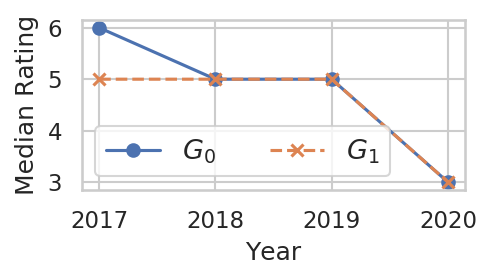

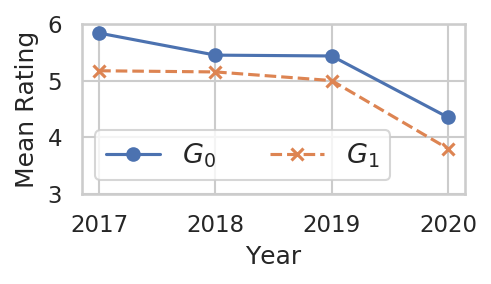

In [6]:
plt.figure(figsize=(3.3, 1.5), dpi=150)
plt.plot([2017, 2018, 2019, 2020],
         [np.percentile(reviews[year][reviews[year]["foreign"]==0]["rating2"], 50.0)
          for year in [2017, 2018, 2019,2020]], color='C0', marker='o', label=r"$G_0$")
plt.plot([2017, 2018, 2019, 2020],
         [np.percentile(reviews[year][reviews[year]["foreign"]==1]["rating2"], 50.0)
          for year in [2017, 2018, 2019,2020]], color='C1', marker='x', mew=1.5, label=r"$G_1$", linestyle="--")
plt.legend(ncol=2, fontsize=13)
plt.yticks([3, 4, 5, 6])
plt.xticks([2017, 2018, 2019, 2020])
plt.xlabel("Year")
plt.ylabel("Median Rating")
plt.show()

plt.figure(figsize=(3.3, 1.5), dpi=150)
plt.plot([2017, 2018, 2019, 2020],
         [np.mean(reviews[year][reviews[year]["foreign"]==0]["rating2"])
          for year in [2017, 2018, 2019,2020]], color='C0', marker='o', label=r"$G_0$")
plt.plot([2017, 2018, 2019, 2020],
         [np.mean(reviews[year][reviews[year]["foreign"]==1]["rating2"])
          for year in [2017, 2018, 2019,2020]], color='C1', marker='x', mew=1.5, label=r"$G_1$", linestyle="--")
plt.legend(ncol=2, fontsize=13)
plt.yticks([3, 4, 5, 6])
plt.xticks([2017, 2018, 2019, 2020])
plt.xlabel("Year")
plt.ylabel("Mean Rating")
plt.show()

## Estimated bias in the peer review ratings (Table 2, left)

Standard errors are clustered by submission ID, since the noise terms in the ratings for each paper may be correlated. This increases the size of the standard errors, widens confidence intervals and makes p-values larger.


In [7]:
for year_pair in [(2017, 2018), (2018, 2019), (2019, 2020)]:
    year1, year2 = year_pair
    df = pd.concat((reviews[year1][["submission_id", "rating2", "foreign", "year"]],
                    reviews[year2][["submission_id", "rating2", "foreign", "year"]]))
    df["y" + str(year2)] = df["year"] == year2
    
    year2str = "C(y" + str(year2) + ")"
    model = sm.ols(formula="rating2 ~ " + year2str + "+ C(~foreign) + " + year2str + ":C(~foreign)", data=df)
    res = model.fit(cov_type="cluster", cov_kwds={'groups': df["submission_id"]})
    
    #print(res.summary()) # UNCOMMENT FOR FULL OLS TABLE
    print("Year pair:", str(year1) + "/" + str(year2), end="\t")
    print("bias={:.3f}".format(res.params[year2str + "[T.True]:C( ~foreign)[T.-1]"]), end="\t")
    print("std. err={:.3f}".format(res.bse[year2str + "[T.True]:C( ~foreign)[T.-1]"]), end="\t")
    print("p-value={:.3f}".format(res.pvalues[year2str + "[T.True]:C( ~foreign)[T.-1]"]), end="\t")
    print("95% CI=({:.3f}, {:.3f})".format(*res.conf_int().loc[year2str + "[T.True]:C( ~foreign)[T.-1]"].values))

Year pair: 2017/2018	bias=-0.369	std. err=0.164	p-value=0.024	95% CI=(-0.690, -0.047)
Year pair: 2018/2019	bias=0.138	std. err=0.112	p-value=0.219	95% CI=(-0.082, 0.358)
Year pair: 2019/2020	bias=0.118	std. err=0.099	p-value=0.236	95% CI=(-0.077, 0.313)


## Estimated bias in the peer review text (Table 2, right)

Note: The code below is multi-threaded and was run on 32 cores. Total running time was < 20 minutes.

### AUC ratio computation function called in each "bootstrap" iteration

In [8]:
def bootstrap_function2(X, y, Xabstract, yabstract, npos, nneg, nposabstract, nnegabstract, seed):
    np.random.seed(seed)
    scipy.random.seed(int(seed/11))

    # downsample + equalize class proportions
    Xpos = resample(X[y==1], n_samples=npos, replace=False, random_state=int(seed/13))
    Xneg = resample(X[y==0], n_samples=nneg, replace=False, random_state=int(seed/13)+5)
    X = scipy.sparse.vstack((Xpos, Xneg))
    y = np.array([1] * npos + [0] * nneg)

    Xabstractpos = resample(Xabstract[yabstract==1], n_samples=nposabstract, replace=False, random_state=int(seed/17))
    Xabstractneg = resample(Xabstract[yabstract==0], n_samples=nnegabstract, replace=False, random_state=int(seed/17)+5)
    Xabstract = scipy.sparse.vstack((Xabstractpos, Xabstractneg))
    yabstract = np.array([1] * nposabstract + [0] * nnegabstract)

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=int(seed/7))
    scores = []
    for train_index, test_index in kf.split(X, y):
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]

        clf = MultinomialNB()
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict_proba(Xtest)[:,1]
        auc_score = roc_auc_score(ytest, ypred)
        scores.append(auc_score)
        
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=int(seed/7)+5)
    abstract_scores = []
    for train_index, test_index in kf.split(Xabstract, yabstract):
        Xtrain, Xtest = Xabstract[train_index], Xabstract[test_index]
        ytrain, ytest = yabstract[train_index], yabstract[test_index]
        
        clf = MultinomialNB()
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict_proba(Xtest)[:,1]
        auc_score = roc_auc_score(ytest, ypred)
        abstract_scores.append(auc_score)
        
    scores = np.array(scores)
    abstract_scores = np.array(abstract_scores)

    return np.mean(scores)/np.mean(abstract_scores)

### ICLR 2017 AUC ratio

In [9]:
year = 2017
review_text = list(reviews[year]["clean_text"].values)
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(review_text)
y = reviews[year]["foreign"].values[:].copy().astype(int)
npos = reviews[2017]["foreign"].sum()
nneg = len(reviews[2017]) - npos

r = reviews[year][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
abstract_text = r["clean_abstract"].values
vectorizer = CountVectorizer(ngram_range=(1, 2))
Xabstract = vectorizer.fit_transform(abstract_text)
yabstract = r["foreign"].values[:].copy()
r = reviews[2017][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
nposabstract = r["foreign"].sum()
nnegabstract = len(r) - nposabstract

nbootstraps = 1000
bootstrap_auc_2017 = process_map(bootstrap_function2,
                                 [X.copy() for i in range(nbootstraps)],
                                 [y.copy() for i in range(nbootstraps)],
                                 [Xabstract.copy() for i in range(nbootstraps)],
                                 [yabstract.copy() for i in range(nbootstraps)],
                                 [npos]*nbootstraps, [nneg]*nbootstraps,
                                 [nposabstract]*nbootstraps, [nnegabstract]*nbootstraps,
                                 np.array(range(nbootstraps)),
                                 max_workers=32)

### ICLR 2018 AUC ratio

In [10]:
year = 2018
review_text = list(reviews[year]["clean_text"].values)
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(review_text)
y = reviews[year]["foreign"].values[:].copy().astype(int)
npos = reviews[2017]["foreign"].sum()
nneg = len(reviews[2017]) - npos

r = reviews[year][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
abstract_text = r["clean_abstract"].values
vectorizer = CountVectorizer(ngram_range=(1, 2))
Xabstract = vectorizer.fit_transform(abstract_text)
yabstract = r["foreign"].values[:].copy()
r = reviews[2017][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
nposabstract = r["foreign"].sum()
nnegabstract = len(r) - nposabstract

nbootstraps = 1000
bootstrap_auc_2018 = process_map(bootstrap_function2,
                                 [X.copy() for i in range(nbootstraps)],
                                 [y.copy() for i in range(nbootstraps)],
                                 [Xabstract.copy() for i in range(nbootstraps)],
                                 [yabstract.copy() for i in range(nbootstraps)],
                                 [npos]*nbootstraps, [nneg]*nbootstraps,
                                 [nposabstract]*nbootstraps, [nnegabstract]*nbootstraps,
                                 np.array(range(nbootstraps)),
                                 max_workers=32)

### ICLR 2019 AUC ratio

In [11]:
year = 2019
review_text = list(reviews[year]["clean_text"].values)
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(review_text)
y = reviews[year]["foreign"].values[:].copy().astype(int)
npos = reviews[2018]["foreign"].sum()
nneg = len(reviews[2018]) - npos

r = reviews[year][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
abstract_text = r["clean_abstract"].values
vectorizer = CountVectorizer(ngram_range=(1, 2))
Xabstract = vectorizer.fit_transform(abstract_text)
yabstract = r["foreign"].values[:].copy()
r = reviews[2018][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
nposabstract = r["foreign"].sum()
nnegabstract = len(r) - nposabstract

nbootstraps = 1000
bootstrap_auc_2019 = process_map(bootstrap_function2,
                                 [X.copy() for i in range(nbootstraps)],
                                 [y.copy() for i in range(nbootstraps)],
                                 [Xabstract.copy() for i in range(nbootstraps)],
                                 [yabstract.copy() for i in range(nbootstraps)],
                                 [npos]*nbootstraps, [nneg]*nbootstraps,
                                 [nposabstract]*nbootstraps, [nnegabstract]*nbootstraps,
                                 np.array(range(nbootstraps)),
                                 max_workers=32)

### ICLR 2020 AUC ratio

In [12]:
year = 2020
review_text = list(reviews[year]["clean_text"].values)
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(review_text)
y = reviews[year]["foreign"].values[:].copy().astype(int)
npos = reviews[2019]["foreign"].sum()
nneg = len(reviews[2019]) - npos

r = reviews[year][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
abstract_text = r["clean_abstract"].values
vectorizer = CountVectorizer(ngram_range=(1, 2))
Xabstract = vectorizer.fit_transform(abstract_text)
yabstract = r["foreign"].values[:].copy()
r = reviews[2019][["submission_id", "clean_abstract", "foreign"]].drop_duplicates()
nposabstract = r["foreign"].sum()
nnegabstract = len(r) - nposabstract

nbootstraps = 1000
bootstrap_auc_2020 = process_map(bootstrap_function2,
                                 [X.copy() for i in range(nbootstraps)],
                                 [y.copy() for i in range(nbootstraps)],
                                 [Xabstract.copy() for i in range(nbootstraps)],
                                 [yabstract.copy() for i in range(nbootstraps)],
                                 [npos]*nbootstraps, [nneg]*nbootstraps,
                                 [nposabstract]*nbootstraps, [nnegabstract]*nbootstraps,
                                 np.array(range(nbootstraps)),
                                 max_workers=32)

### Difference in AUC ratio between consecutive year pairs (Table 2, right)

Note: p-values computed from emprical confidence intervals as suggested here: https://www.bmj.com/content/343/bmj.d2304

In [13]:
def get_p_value(est, ci):
    l, u = ci
    se = (u - l)/(2 * 1.96)
    z = np.abs(est/se)
    p = np.exp(-0.717*z - 0.416*z*z)
    return p

# compute distribution of differences in AUC ratios in each consecutive year pair
diff_2017_2018 = np.array(bootstrap_auc_2018) - np.array(bootstrap_auc_2017) 
diff_2018_2019 = np.array(bootstrap_auc_2019) - np.array(bootstrap_auc_2018) 
diff_2019_2020 = np.array(bootstrap_auc_2020) - np.array(bootstrap_auc_2019)

print("AUC Ratio in ICLR 2018 - ICLR 2017:\n",
      "\tmean (bias)={:.3f}".format(np.mean(diff_2017_2018)),
      "  std. error={:.3f}".format(np.std(diff_2017_2018)),
      "  p-value={:.3f}".format(get_p_value(np.mean(diff_2017_2018),
                                               np.percentile(diff_2017_2018, [2.5, 97.5]))),
      "\t95% CI=({:.3f}, {:.3f})".format(*np.percentile(diff_2017_2018, [2.5, 97.5])))
print("AUC Ratio in ICLR 2019 - ICLR 2018:\n",
      "\tmean (bias)={:.3f}".format(np.mean(diff_2018_2019)),
      "  std. error={:.3f}".format(np.std(diff_2018_2019)),
      "  p-value={:.3f}".format(get_p_value(np.mean(diff_2018_2019),
                                               np.percentile(diff_2018_2019, [2.5, 97.5]))),
      "\t95% CI=({:.3f}, {:.3f})".format(*np.percentile(diff_2018_2019, [2.5, 97.5])))
print("AUC Ratio in ICLR 2020 - ICLR 2019:\n",
      "\tmean (bias)={:.3f}".format(np.mean(diff_2019_2020)),
      "  std. error={:.3f}".format(np.std(diff_2019_2020)),
      "  p-value={:.3f}".format(get_p_value(np.mean(diff_2019_2020),
                                               np.percentile(diff_2019_2020, [2.5, 97.5]))),
      "\t95% CI=({:.3f}, {:.3f})".format(*np.percentile(diff_2019_2020, [2.5, 97.5])))

AUC Ratio in ICLR 2018 - ICLR 2017:
 	mean (bias)=-0.166   std. error=0.055   p-value=0.002 	95% CI=(-0.270, -0.063)
AUC Ratio in ICLR 2019 - ICLR 2018:
 	mean (bias)=-0.070   std. error=0.068   p-value=0.308 	95% CI=(-0.195, 0.072)
AUC Ratio in ICLR 2020 - ICLR 2019:
 	mean (bias)=0.012   std. error=0.043   p-value=0.781 	95% CI=(-0.082, 0.083)
